>###  The Cannon is a machine learning program that can be trained on a set of stellar parameters ("labels") and spectroscopic data. This provides a model that should predict what physical attributes will accompany given spectra. Below, the Cannon is loaded with stellar parameters from APOGEE and photometry from GAIA/APOGEE/DDO51. The model is trained and then tested using the same data set. The effectiveness of the model is then evaluated via comparison of input and returned values. Then, as a visual means of ascertaining how well the Cannon did, stellar parameters are plotted in a color-color diagram.

In [38]:
# Import libraries and modules
import thecannon as tc
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import the calibration data
cat = fits.getdata('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')
labelled_set = Table.read('C:\\Users\\shebe\\OneDrive\\School\\Graduate\\Research\\Nidever\\Data\\apogeegaia_giants.fits.gz')

#Filter out bad MgH values
ind = np.where(labelled_set['MGH']<10)
labelled_set = labelled_set[ind]
cat = cat[ind]

#columns to remove from data
rmclm = [i for i in labelled_set.colnames if i!= 'MGH' and i!= 'TEFF' and i!= 'LOGG']
labelled_set.remove_columns(rmclm)
num = len(labelled_set)

#Make new array for normalized_flux (photometric data)
normalized_flux = np.array([[cat['BP'][i]-cat['RP'][i],
                             cat['BP'][i]-cat['DDO51'][i],
                             cat['BP'][i]-cat['J'][i]] for i in range(0,num)])
###np.info(normalized_flux)

#Make new array for normalized_flux (photometric data)
#Construct inverse variance for all colors
#TYPO WAS HERE: DIVIDED BY bprp_error ON ALL ivar's
bprp_error = np.sqrt(cat['BPERR']**2+cat['RPERR']**2)
bprp_ivar = 1.0/(bprp_error**2)

bpddo51_error = np.sqrt(cat['BPERR']**2+cat['DDO51_ERR']**2)
bpddo51_ivar = 1.0/(bpddo51_error**2)

bpj_error = np.sqrt(cat['BPERR']**2+cat['J_ERR']**2)
bpj_ivar = 1.0/(bpj_error**2)

normalized_ivar = np.array([[bprp_ivar[i],
                             bpddo51_ivar[i],
                             bpj_ivar[i]] for i in range(0,num)])

num

4397

In [39]:
#Keep inverse variance greater than 10,000
ind = np.where((bprp_ivar<5e5)&(bpddo51_ivar<5e5)&(bpj_ivar<5e5))
normalized_ivar = normalized_ivar[ind]
normalized_flux = normalized_flux[ind]
labelled_set = labelled_set[ind]
len(normalized_flux)

3446

>### Below I ran the Cannon with 1st order, 2nd order, and 3rd order polynomials.

In [74]:
#A 1st order polynomial
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 1)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + LOGG + MGH'

In [75]:
# TRAIN THE MODEL
nr_theta, nr_s2, nr_metadata = model.train()  

# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-05 13:32:09,519 [INFO] Training 3-label CannonModel with 3446 stars and 3 pixels/star
2018-10-05 13:32:09,571 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-05 13:32:09,636 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-05 13:32:09,639 [INFO] Running test step on 3446 spectra


[=====================================================================================================] 100% (19s)                                


TEFF bias = 248.950 scatter = 559.547
LOGG bias = 0.070 scatter = 0.822
MGH bias = 1.256 scatter = 2.803


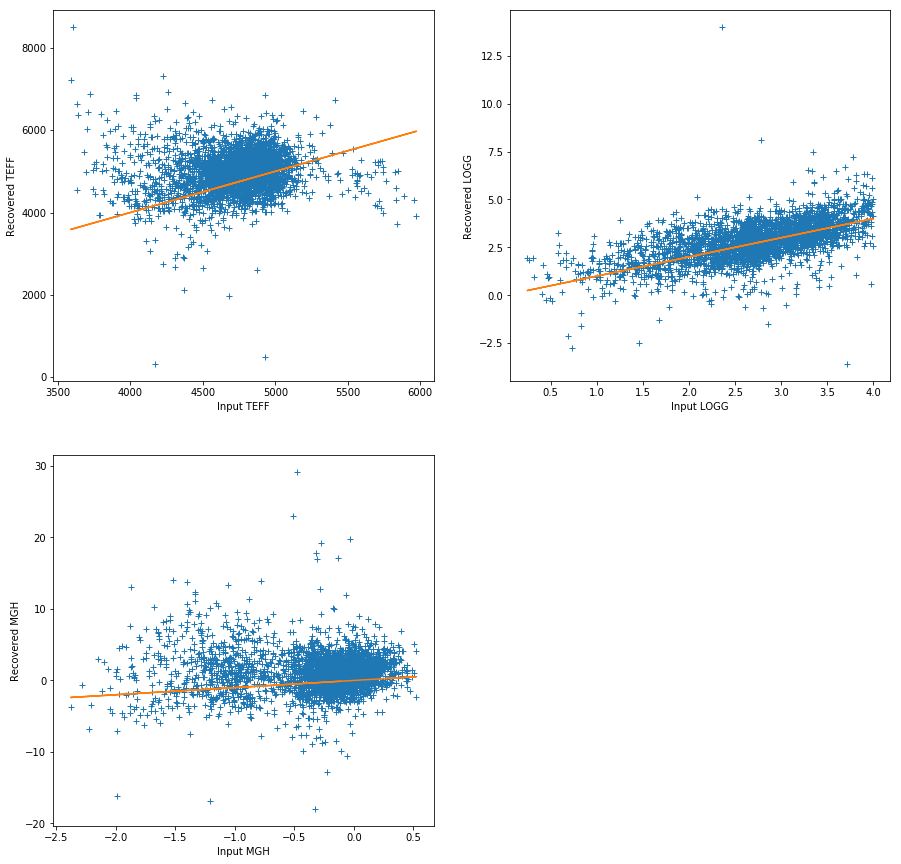

In [76]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
pol1 = []
for i in range(0,3):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    pol1.append(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]))

print(pol1[0])
print(pol1[1])
print(pol1[2])   

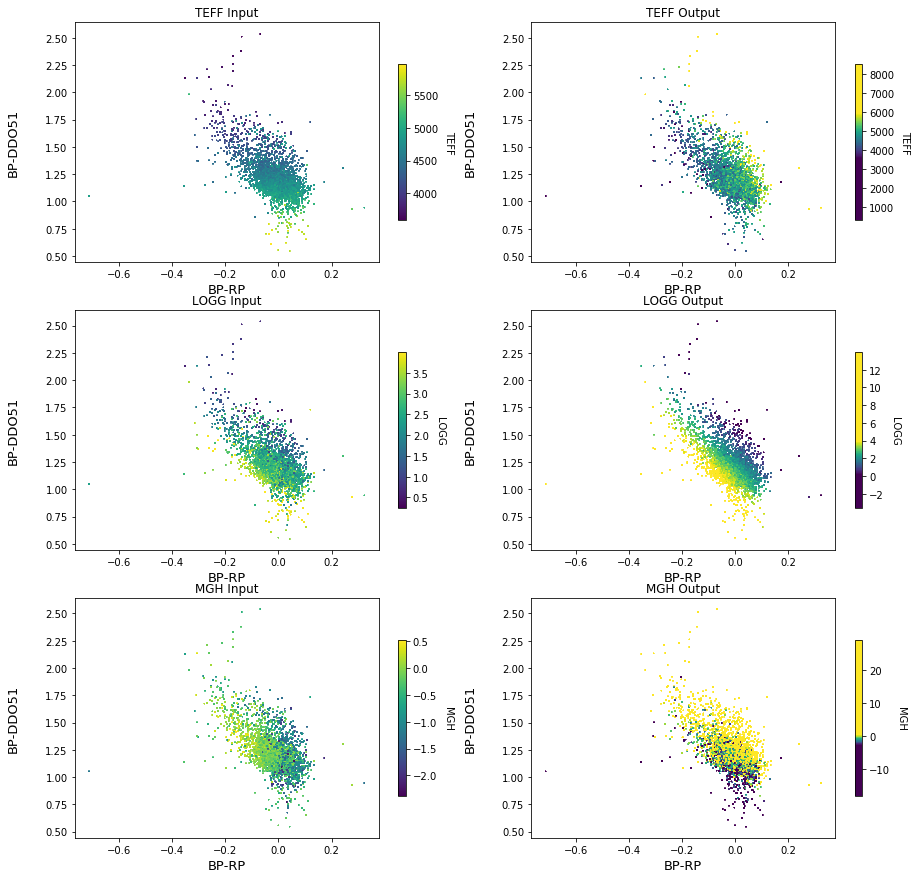

In [55]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,3):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
   
    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
        
plt.show()

In [77]:
#2nd order polynomial
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 2)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + LOGG + MGH + TEFF^2 + LOGG*TEFF + MGH*TEFF + LOGG^2 + LOGG*MGH + MGH^2'

In [78]:
# TRAIN THE MODEL
nr_theta, nr_s2, nr_metadata = model.train()  

# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-05 13:32:46,396 [INFO] Training 3-label CannonModel with 3446 stars and 3 pixels/star
2018-10-05 13:32:46,424 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-05 13:32:46,477 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-05 13:32:46,479 [INFO] Running test step on 3446 spectra


[=====================================================================================================] 100% (45s)                                


TEFF bias = 36.326 scatter = 168.462
LOGG bias = -0.031 scatter = 0.702
MGH bias = 0.013 scatter = 0.449


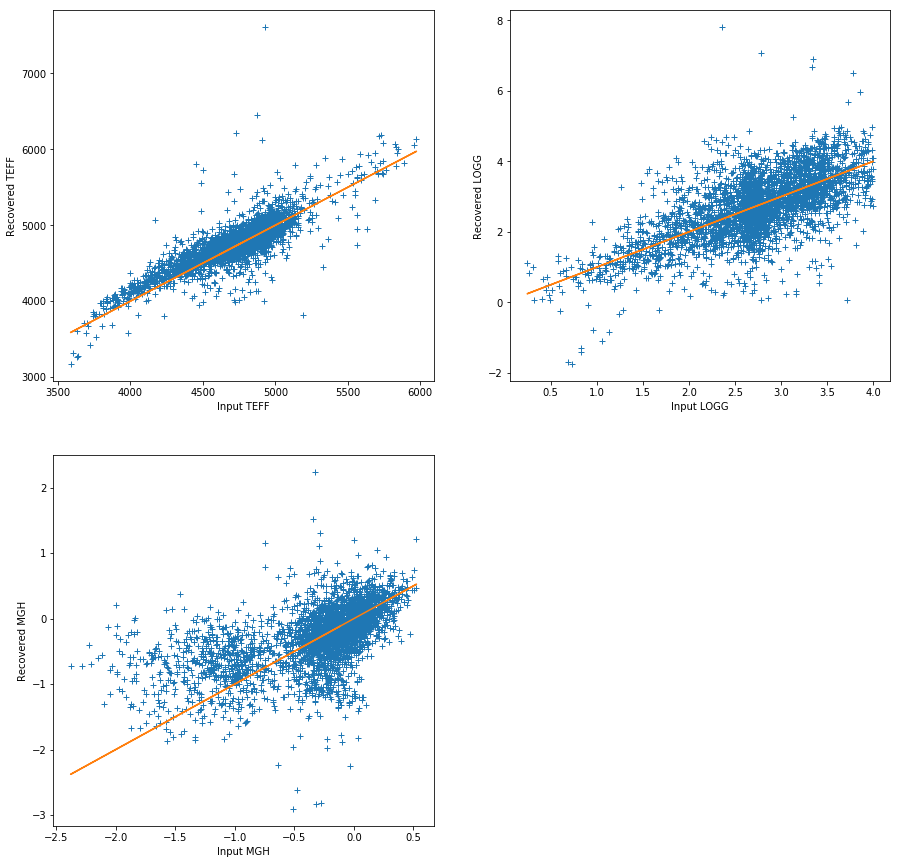

In [79]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
pol2 = []
for i in range(0,3):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    pol2.append(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]))

print(pol2[0])
print(pol2[1])
print(pol2[2])

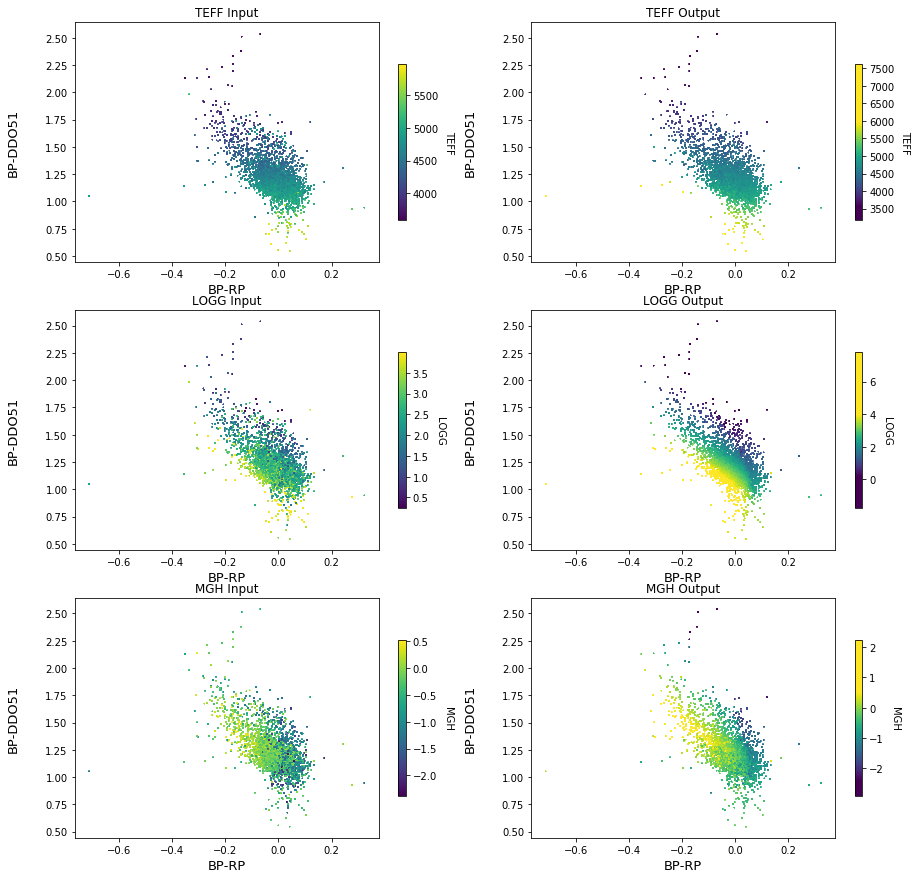

In [59]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,3):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
   
    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
        
plt.show()

In [80]:
#3rd order polynomial
vec = tc.vectorizer.PolynomialVectorizer(labelled_set.colnames, 3)
model = tc.CannonModel(labelled_set, normalized_flux, normalized_ivar, vec)
model.regularization = 0   # no regularization for now
vec.get_human_readable_label_vector()

'1 + TEFF + LOGG + MGH + TEFF^2 + LOGG*TEFF + MGH*TEFF + LOGG^2 + LOGG*MGH + MGH^2 + TEFF^3 + LOGG*TEFF^2 + MGH*TEFF^2 + LOGG^2*TEFF + LOGG*MGH*TEFF + MGH^2*TEFF + LOGG^3 + LOGG^2*MGH + LOGG*MGH^2 + MGH^3'

In [81]:
# TRAIN THE MODEL
nr_theta, nr_s2, nr_metadata = model.train()  

# Test/fit the spectra to get the labels
labels5, cov, meta = model.test(normalized_flux, normalized_ivar)

2018-10-05 13:34:10,564 [INFO] Training 3-label CannonModel with 3446 stars and 3 pixels/star
2018-10-05 13:34:10,615 [DEBUG] Couldn't get screen size. Progressbar may look odd.


[===                                                                                                 ] 100% (0s)                           


2018-10-05 13:34:10,681 [DEBUG] Couldn't get screen size. Progressbar may look odd.
2018-10-05 13:34:10,683 [INFO] Running test step on 3446 spectra


[=====================================================================================================] 100% (102s)                               


TEFF bias = 36.741 scatter = 301.191
LOGG bias = 0.150 scatter = 0.821
MGH bias = 0.250 scatter = 0.688


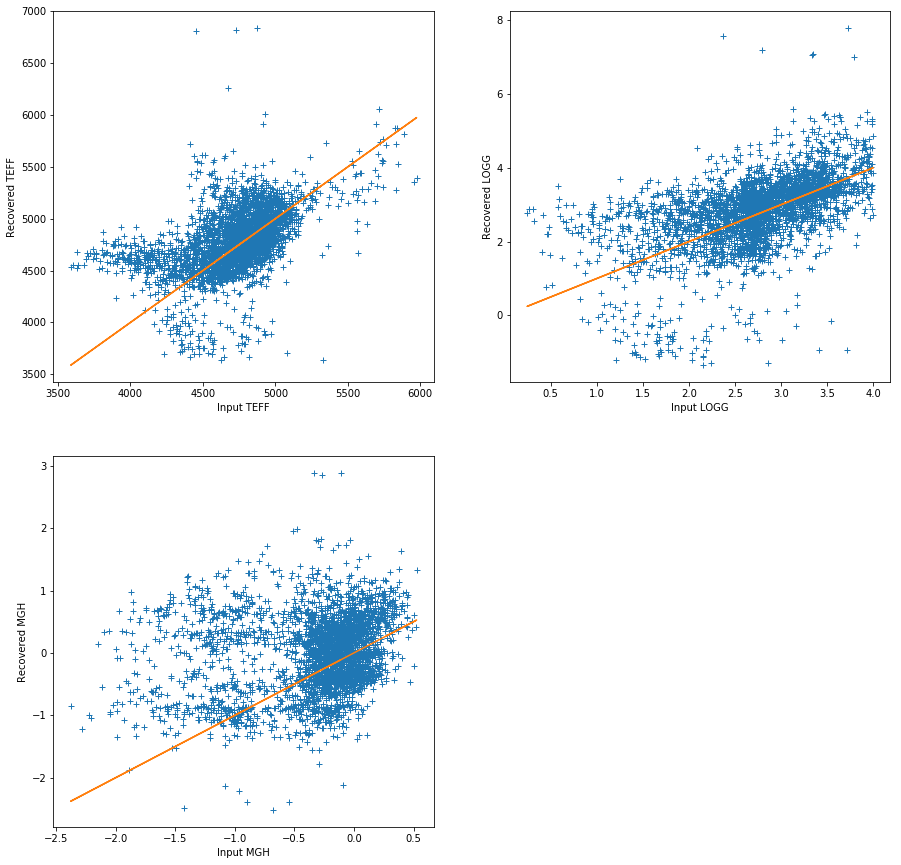

In [82]:
# one-to-one comparisons
names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))
pol3 = []
for i in range(0,3):
    plt.subplot(2, 2, i+1)
    plt.plot(labelled_set[names[i]],labels5[:,i],'+')
    plt.plot(labelled_set[names[i]],labelled_set[names[i]])
    plt.xlabel('Input '+names[i])
    plt.ylabel('Recovered '+names[i])
    pol3.append(names[i]+' bias = %.3f' % np.median(labels5[:,i]-labelled_set[names[i]])+' scatter = %.3f' % np.std(labels5[:,i]-labelled_set[names[i]]))
    
print(pol3[0])
print(pol3[1])
print(pol3[2])

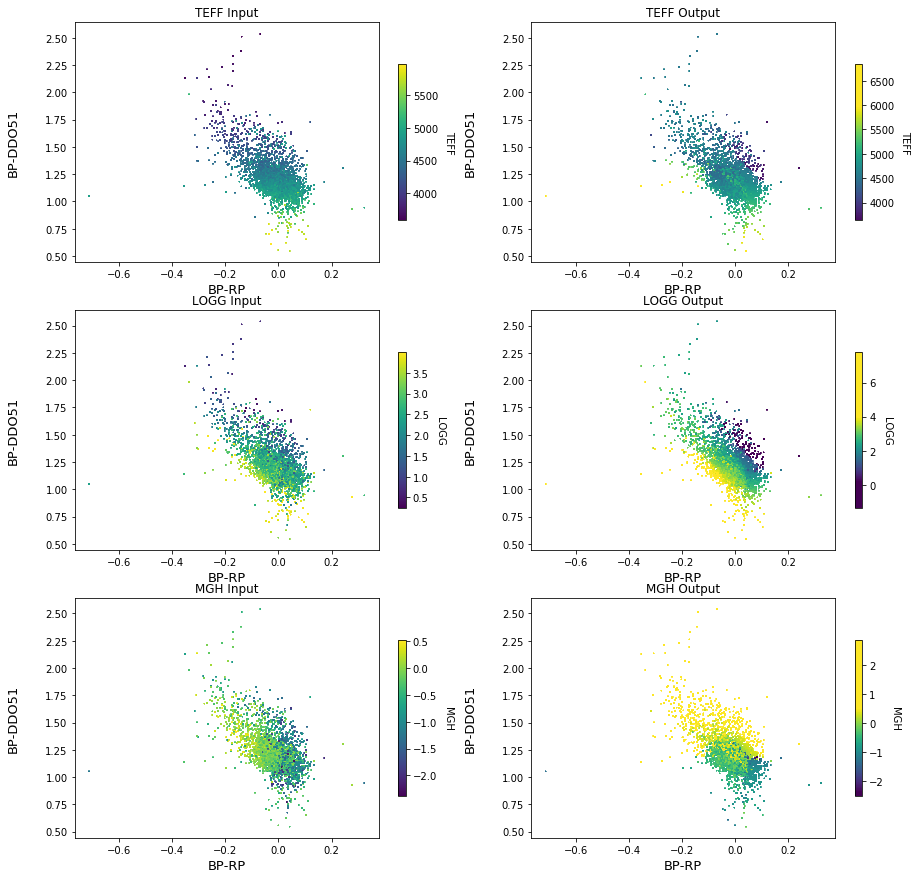

In [63]:
#Plotting how well input and output data correlate for the three physical parameters
y=normalized_flux[:,0]
x=normalized_flux[:,1]

names = model.vectorizer.label_names
fig = plt.figure(figsize=(15,15))

    
for i in range(0,3):
    
    plt.subplot(3, 2, 2*i+1)
    plt.title("{0} Input".format(names[i]))
    plt.scatter(x,y,marker='+',c=labelled_set[names[i]],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
   
    plt.subplot(3, 2, 2*i+2)
    plt.title("{0} Output".format(names[i]))
    plt.scatter(x,y,marker='+',c=labels5[:,i],s=3)
    plt.xlabel('BP-RP',fontsize=13)
    plt.ylabel('BP-DDO51',rotation='vertical',labelpad=25,fontsize=13)
    cbar = plt.colorbar(shrink=0.65)
    cbar.set_label(names[i], rotation=270, labelpad=+16)
    cbar.set_clim(min(labelled_set[names[i]]),max(labelled_set[names[i]]))
        
plt.show()

>### Here I compare how all the different trainings went based on the order of polynomial.

In [83]:
print('1st order polynomial:')
print(pol1[0])
print(pol1[1])
print(pol1[2])
print('')
print('2nd order polynomial:')
print(pol2[0])
print(pol2[1])
print(pol2[2])
print('')
print('3rd order polynomial:')
print(pol3[0])
print(pol3[1])
print(pol3[2])

1st order polynomial:
TEFF bias = 248.950 scatter = 559.547
LOGG bias = 0.070 scatter = 0.822
MGH bias = 1.256 scatter = 2.803

2nd order polynomial:
TEFF bias = 36.326 scatter = 168.462
LOGG bias = -0.031 scatter = 0.702
MGH bias = 0.013 scatter = 0.449

3rd order polynomial:
TEFF bias = 36.741 scatter = 301.191
LOGG bias = 0.150 scatter = 0.821
MGH bias = 0.250 scatter = 0.688
